In [1]:
import gc
import logging
logging.disable(logging.WARNING)
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import mixed_precision
from tensorflow.keras.utils import plot_model
import tensorflow_probability as tfp

mixed_precision.set_global_policy('mixed_float16')
print(tf.__version__)

2.6.3


In [3]:
# Load data
# df = pd.read_parquet('E:/train_low_mem.parquet')
df = pd.read_csv('kaggle/input/ubiquant-market-prediction/train.csv', engine='c', nrows=5000)
df.drop(['row_id'], inplace=True, axis=1)
investment_id = df['investment_id']
df = df.groupby(['time_id'])
x, x_id, y = [], [], []
for timestep in df:
    timestep = timestep[1]  # remove pd added index tuple
    x.append(timestep.loc[:, 'f_0':'f_299'].to_numpy())
    x_id.append(timestep['investment_id'].to_numpy())
    y.append(timestep['target'].to_numpy())

investment_ids = list(investment_id.unique())
investment_id_lookup_layer = IntegerLookup(oov_token=-1, output_mode='int')
investment_id_lookup_layer.adapt(np.array(investment_ids))
vocab = investment_id_lookup_layer.get_vocabulary(include_special_tokens=True)
vocab_size = investment_id_lookup_layer.vocabulary_size()
print(max(investment_ids))
print(vocab_size)
assert len(x) == len(y)

3772
2301


In [4]:
def preprocess(x, x_id, y):
    global x_time, width, num_remaining, remaining_slice, rows_to_fill, padded_remaining
    x_time = [tf.convert_to_tensor(s, dtype=tf.float16) for s in x]
    width = x_time[0].shape[1]  # should be 300 (no of features)
    num_remaining = [s.shape[0]%width for s in x_time]  # remaining rows less than 300
    remaining_slice = [x_time[i][-num_remaining[i]:] for i in range(len(x_time))]
    rows_to_fill = [width-r for r in num_remaining]
    padded_remaining = [tf.concat([remaining_slice[i], tf.cast(tf.zeros([rows_to_fill[i], width]), tf.float16)], axis=0) for i in range(len(x_time))]
    x_time = [tf.concat([x_time[i], padded_remaining[i]], axis=0) for i in range(len(x_time))]  # concat padded remaining rows to already split rows
    x_time = [tf.reshape(s[:-(s.shape[0]%width)], (-1, width, width)) for s in x_time]  # reshape automatically split rows
    x_time = [[x_time] * len(s) for s in x]
    return (x, x_id, x_time), y  # x_time is a list of same images of n x 300 x 300, same across a time step

# Pearson correlation coefficient loss and metrics
def pearson_corr(y_true, y_pred, axis=-1):
    return tfp.stats.correlation(tf.squeeze(y_pred), tf.squeeze(y_true), sample_axis=axis, event_axis=None)

def pearson_corr_loss(y_true, y_pred, axis=-1):
    return (1 - pearson_corr(y_true, y_pred, axis=axis)) + 2 * tf.keras.metrics.mean_squared_error(y_true, y_pred)

In [5]:
print('Preprocessing dataset')
ds = preprocess(x, x_id, y)

# def make_dataset(ds, batch_size=64, mode='train'):
#     single_x = []
#     single_x_id = []
#     single_y = []
#     single_x_time = []
#     x = ds[0][0]
#     x_id = ds[0][1]
#     x_time = ds[0][2]
#     y = ds[1]
#     print('Iterating through dataset')
#     for time_id in range(len(x)):
#         for sample in x[time_id]:
#             single_x.append(sample)
#         for sample in x_id[time_id]:
#             single_x_id.append(sample)
#         for sample in y[time_id]:
#             single_y.append(sample)
#         single_x_time += [x_time[time_id]] * len(x[time_id])
#     return (single_x, single_x_id, single_x_time), single_y

print('Done')

Preprocessing dataset
Done


In [ ]:
print(len(ds))

In [10]:
def build_model():
    investment_id_inputs = Input((1, ), name='inv_id_in', dtype=tf.uint8)
    features_inputs = Input((300,), name='feature_in', dtype=tf.float16)
    time_context_inputs = Input((None, 300, 300), name='context_in', dtype=tf.float16)

    investment_id_x = investment_id_lookup_layer(investment_id_inputs)
    investment_id_x = Embedding(vocab_size, 64, input_length=1)(investment_id_x)
    investment_id_x = Reshape((-1, ))(investment_id_x)
    investment_id_x = Dense(64, activation='swish')(investment_id_x)
    # investment_id_x = Dropout(0.2)(investment_id_x)
    investment_id_x = Dense(64, activation='swish')(investment_id_x)
    # investment_id_x = Dropout(0.2)(investment_id_x)
    investment_id_x = Dense(64, activation='swish')(investment_id_x)
    # investment_id_x = Dropout(0.2)(investment_id_x)

    feature_x = GaussianNoise(0.01)(features_inputs)
    feature_x = Dense(256, activation='swish')(feature_x)
    # feature_x = Dropout(0.2)(feature_x)
    feature_x = Dense(256, activation='swish')(feature_x)
    # feature_x = Dropout(0.2)(feature_x)
    feature_x = Dense(256, activation='swish')(feature_x)
    # feature_x = Dropout(0.2)(feature_x)

    time_context_x = Conv2D(128, (3, 3))(time_context_inputs)
    time_context_x = Flatten()(time_context_x)

    x = Concatenate(axis=1)([investment_id_x, feature_x, time_context_x])
    x = Dense(512, activation='swish', kernel_regularizer="l2")(x)
    # x = LayerNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='swish', kernel_regularizer="l2")(x)
    # x = LayerNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='swish', kernel_regularizer="l2")(x)
    # x = LayerNormalization()(x)
    x = Dropout(0.2)(x)
    xOut = Dense(1, name='output')(x)

    model = Model(inputs=[investment_id_inputs, features_inputs], outputs=[xOut])
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=7e-4), metrics=[pearson_corr, 'mse'])
    return model

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inv_id_in (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
integer_lookup_1 (IntegerLookup (None, 1)            0           inv_id_in[0][0]                  
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 64)        177856      integer_lookup_1[0][0]           
__________________________________________________________________________________________________
feature_in (InputLayer)         [(None, 900)]        0                                            
____________________________________________________________________________________________

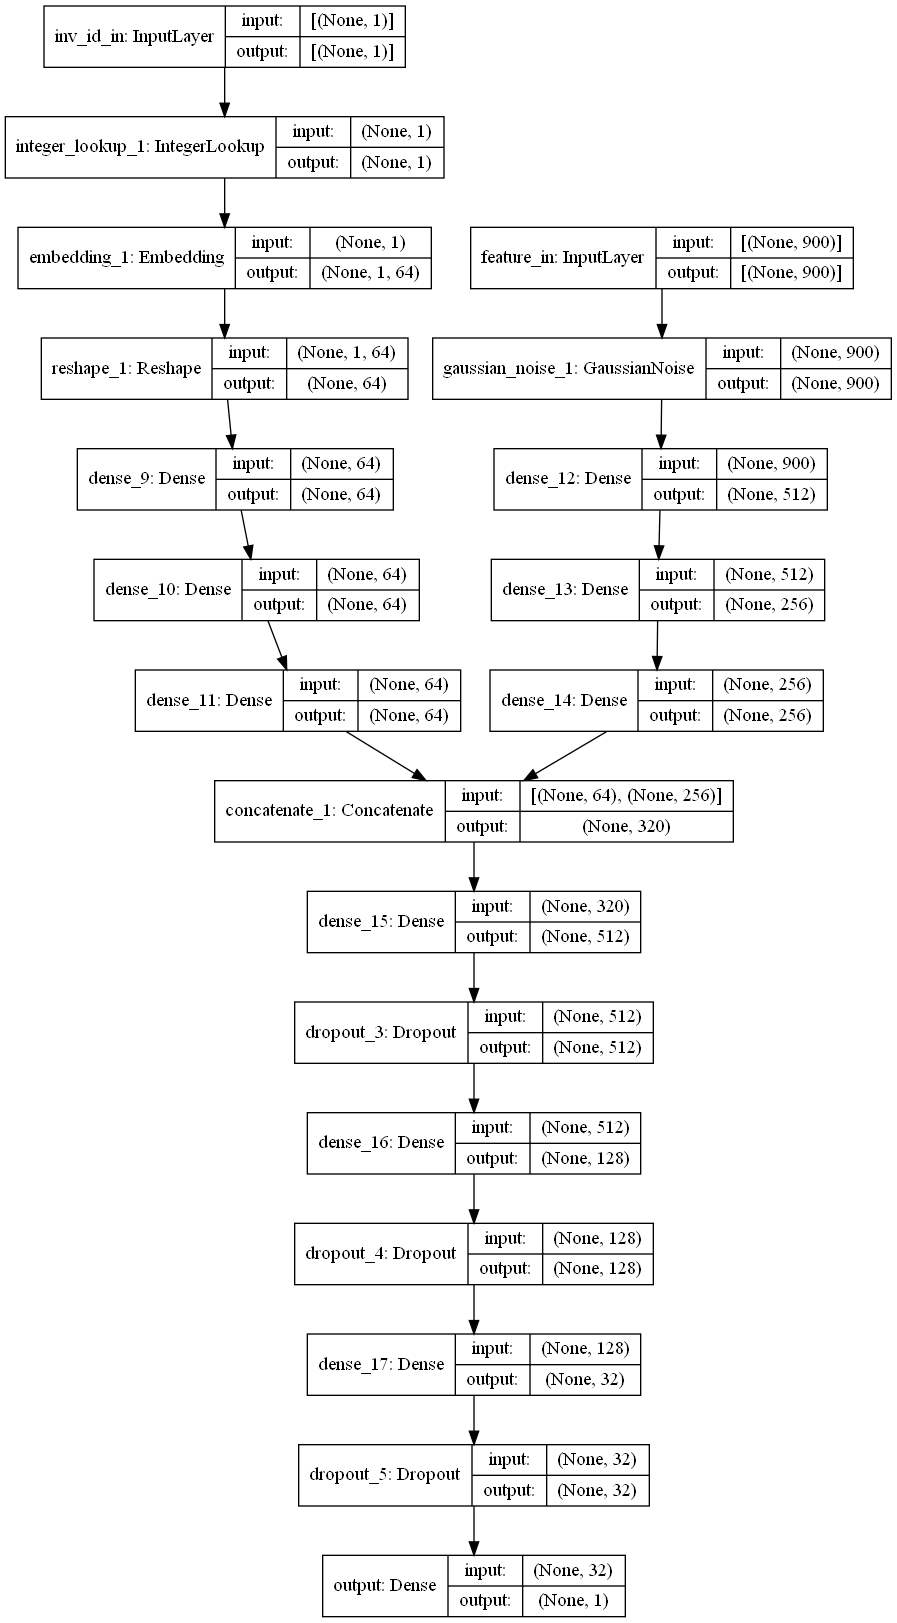

In [11]:
model = build_model()
model.summary()
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
import scipy
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=69)
# group_time_series_split = GroupTimeSeriesSplit(n_folds=6, holdout_size=200, groups=df_with_time_feat['time_id'])
models = []
# del df
for index, (train_indices, valid_indices) in enumerate(kfold.split(df_with_time_feat, df_with_time_feat['time_id'])):
    print(f'Model {index}')
    train = df_with_time_feat.drop(['time_id', 'investment_id'], axis=1)
    X_train, X_val = train.iloc[train_indices], train.iloc[valid_indices]
    investment_id_train = investment_id[train_indices]
    y_train, y_val = y.iloc[train_indices], y.iloc[valid_indices]
    investment_id_val = investment_id[valid_indices]
    train_ds = make_dataset(X_train, investment_id_train, y_train)
    valid_ds = make_dataset(X_val, investment_id_val, y_val, mode="valid")
    model = build_model()
    callbacks = [tf.keras.callbacks.ModelCheckpoint(f"model_{index}", monitor='val_mse', save_best_only=True, mode='min'),
                 tf.keras.callbacks.EarlyStopping(patience=13, monitor='val_mse', verbose=1, restore_best_weights=True, mode='min'),
                 tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=6, verbose=1, monitor='val_mse', mode='min'),
                 tf.keras.callbacks.TerminateOnNaN()]
    history = model.fit(train_ds, epochs=100, validation_data=valid_ds, callbacks=callbacks)
    models.append(load_model(f"model_{index}", custom_objects={'pearson_corr': pearson_corr, 'pearson_corr_loss': pearson_corr_loss}))

    pearson_score = scipy.stats.pearsonr(model.predict(valid_ds).ravel(), y_val.values)[0]
    print('Pearson:', pearson_score)
    del investment_id_train
    del investment_id_val
    del X_train
    del X_val
    del y_train
    del y_val
    del train_ds
    del valid_ds
    del model
    gc.collect()

Model 0
Epoch 1/100
407/407 [==============================] - 13s 18ms/step - loss: 1.2888 - pearson_corr: 0.1279 - mse: 0.8276 - val_loss: 0.8410 - val_pearson_corr: 0.1342 - val_mse: 0.8378
Epoch 2/100
407/407 [==============================] - 8s 20ms/step - loss: 0.8253 - pearson_corr: 0.1454 - mse: 0.8222 - val_loss: 0.8393 - val_pearson_corr: 0.1436 - val_mse: 0.8361


In [3]:
from ubiquantEmulator import TimeSeriesAPI

def preprocess_test(investment_id, feature):
    return (investment_id, feature), 0

def make_test_dataset(feature, investment_id, batch_size=2048):
    ds = tf.data.Dataset.from_tensor_slices(((investment_id, feature)))
    ds = ds.map(preprocess_test)
    ds = ds.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
    return ds


def inference(models, ds):
    y_preds = []
    for model in models:
        y_pred = model.predict(ds)
        y_preds.append(y_pred)
    return np.mean(y_preds, axis=0)  # ensemble

# models = [load_model(f"2/model_{index}", custom_objects={'pearson_corr': pearson_corr, 'pearson_corr_loss': pearson_corr_loss}) for index in range(5)]
# models = [load_model(f"model_comb", custom_objects={'pearson_corr': pearson_corr, 'pearson_corr_loss': pearson_corr_loss})]
# models += [load_model(f"1/model_{index}", custom_objects={'pearson_corr': pearson_corr, 'pearson_corr_loss': pearson_corr_loss}) for index in range(6)]
# test = pd.read_parquet('E:/train_low_mem.parquet')
# time_ids = df['time_id'].unique()
# test = test.loc[test['time_id'].isin(time_ids)]  # take last 200 time id rows from df
test = pd.read_csv('kaggle/input/ubiquant-market-prediction/train.csv', engine='pyarrow')
iter_test = TimeSeriesAPI(test)
for n, (test_df, sample_prediction_df) in enumerate(iter_test):
    # ds = make_test_dataset(test_df.loc[:, 'f_0':'f_299'], test_df["investment_id"])
    print(test_df)
    break
    sample_prediction_df['target'] = 0
    iter_test.predict(sample_prediction_df)
print(sample_prediction_df)
print(f'Pearson: {iter_test.score()}')

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set. ;)
            row_id  time_id  investment_id       f_0       f_1       f_2  \
0        0     0_1        0              1  0.932573  0.113691 -0.402206   
1        1     0_2        0              2  0.810802 -0.514115  0.742368   
2        2     0_6        0              6  0.393974  0.615937  0.567806   
3        3     0_7        0              7 -2.343535 -0.011870  1.874606   
4        4     0_8        0              8  0.842057 -0.262993  2.330030   
...    ...     ...      ...            ...       ...       ...       ...   
2267  2267  0_3766        0           3766  0.608746  0.113691 -1.139019   
2268  2268  0_3768        0           3768  0.045162 -0.262993  0.442972   
2269  2269  0_3769        0           3769 -0.228024 -0.137431  1.119442   
2270  2270  0_3770        0           3770  0.908744  0.490375  1.018606   
2271  2271  0_3772        0         

ValueError: No objects to concatenate